# Preparation for Group Assignment

This tutorial contains various small guides for tasks you will need or come in handy in the upcoming group assignment.

We're going to need a couple of packages for this tutorial:

In [19]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import atlite


## Preparatory Downloads

For this tutorial, we also need to download a few files, for which one can use the `urllib` library:

In [20]:
from urllib.request import urlretrieve

In [21]:
fn = "era5-2013-NL.nc"
url = "https://tubcloud.tu-berlin.de/s/bAJj9xmN5ZLZQZJ/download/" + fn
urlretrieve(url, )

('era5-2013-NL.nc', <http.client.HTTPMessage at 0x7f140a5ef040>)

In [22]:
fn = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-NL.tif'
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files={fn}"
urlretrieve(url, fn)

('PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-NL.tif',
 <http.client.HTTPMessage at 0x7f140a5ef490>)

In [23]:
fn = 'WDPA_Oct2022_Public_shp-NLD.tif'
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files={fn}"
urlretrieve(url, fn)

('WDPA_Oct2022_Public_shp-NLD.tif',
 <http.client.HTTPMessage at 0x7f140a5ef5e0>)

In [24]:
fn = 'GEBCO_2014_2D-NL.nc'
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files={fn}"
urlretrieve(url, fn)

('GEBCO_2014_2D-NL.nc', <http.client.HTTPMessage at 0x7f140a5ee7a0>)

## Downloading historical weather data from ERA5 with `atlite`

First, let's load some small example country. Let's say, the Netherlands.

In [29]:
fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)

<AxesSubplot:>

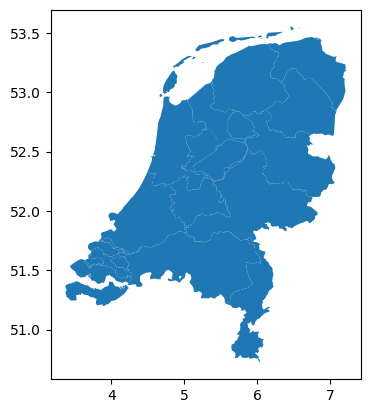

In [30]:
regions.plot()

In this example we download historical weather data [ERA5 data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) on-demand for a cutout we want to create.

:::{note}
For this example to work, you should have
- installed the Copernicus Climate Data Store `cdsapi` package (`conda list cdsapi` or `pip install cdsapi`) and
- registered and setup your CDS API key as described on [this website](https://cds.climate.copernicus.eu/api-how-to). Note that there are different instructions depending on your operating system.
:::

A **cutout** is the basis for any of your work and calculations in `atlite`.

The cutout is created in the directory and file specified by the relative path. If a cutout at the given location already exists, then this command will simply load the cutout again. If the cutout does not yet exist, it will specify the new cutout to be created.

For creating the cutout, you need to specify the dataset (e.g. ERA5), a time period and the spatial extent (in latitude and longitude).

In [31]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

In [32]:
cutout = atlite.Cutout(
   path="era5-2013-NL.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2013",
)

/home/fneum/miniconda3/envs/pypsa-eur-221227/lib/python3.10/site-packages/atlite/cutout.py:187: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


Calling the function `cutout.prepare()` initiates the download and processing of the weather data.
Because the download needs to be provided by the CDS servers, this might take a while depending on the amount of data requested.

:::{note}
You can check the status of your request [here](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests).
:::

In [33]:
cutout.prepare()

<Cutout "era5-2013-NL">
 x = 3.25 ⟷ 7.25, dx = 0.25
 y = 50.50 ⟷ 53.75, dy = 0.25
 time = 2013-01-01 ⟷ 2013-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

The data is accessible in `cutout.data`. Included weather variables are listed in `cutout.prepared_features`. Querying the `cutout` gives us some basic information on which data is contained in it.

In [34]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 17, y: 14, time: 8760)
Coordinates:
  * x                 (x) float64 3.25 3.5 3.75 4.0 4.25 ... 6.5 6.75 7.0 7.25
  * y                 (y) float64 50.5 50.75 51.0 51.25 ... 53.25 53.5 53.75
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(17,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(14,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(14, 17), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 14, 17), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['influx', 'wind', 'height', 'temperature', 'runoff']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-01-15 21:33:09 GMT by grib_to_netcdf-2.25.1: /op...

In [35]:
cutout.prepared_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

In [36]:
cutout

<Cutout "era5-2013-NL">
 x = 3.25 ⟷ 7.25, dx = 0.25
 y = 50.50 ⟷ 53.75, dy = 0.25
 time = 2013-01-01 ⟷ 2013-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

## Repetition: From Land Eligibility Analysis to Availability Matrix

We're going to use the plotting functions from previous exercises:

In [37]:
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

First, we collect all exclusion and inclusion criteria in an `ExclusionContainer`.

In [44]:
excluder = ExclusionContainer(crs=3035, res=300)
fn = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-NL.tif'
excluder.add_raster(fn, codes=[50], buffer=1000, crs=4326)
excluder.add_raster(fn, codes=[20,30,40,60], crs=4326, invert=True)
fn = 'WDPA_Oct2022_Public_shp-NLD.tif'
excluder.add_raster(fn, crs=3035)
fn = 'GEBCO_2014_2D-NL.nc'
excluder.add_raster(fn, codes=lambda x: x>10, crs=4326, invert=True)

Then, we can calculate the available areas...

In [45]:
masked, transform = shape_availability(regions.to_crs(3035).geometry, excluder)

/home/fneum/miniconda3/envs/pypsa-eur-221227/lib/python3.10/site-packages/atlite/gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


... and plot it:

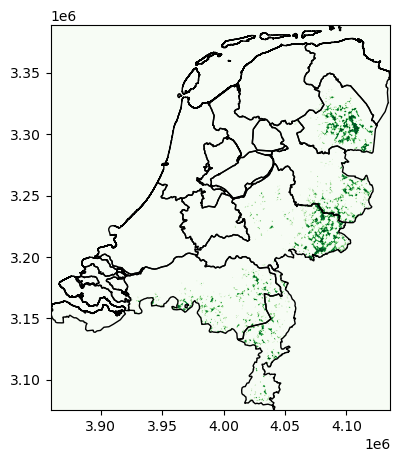

In [46]:
plot_area(masked, transform, regions.to_crs(3035).geometry)

### Availability Matrix

In [47]:
regions.index = regions.GID_1

In [48]:
cutout = atlite.Cutout("era5-2013-NL.nc")

In [49]:
cutout.availabilitymatrix?

Signature:
cutout.availabilitymatrix(
    shapes,
    excluder,
    nprocesses=None,
    disable_progressbar=False,
)
Docstring:
Compute the eligible share within cutout cells in the overlap with shapes.

For parallel calculation (nprocesses not None) the excluder must not be
initialized and all raster references must be strings. Otherwise processes
are colliding when reading from one common rasterio.DatasetReader.

Parameters
----------
cutout : atlite.Cutout
    Cutout which the availability matrix is aligned to.
shapes : geopandas.Series/geopandas.DataFrame
    Geometries for which the availabilities are calculated.
excluder : atlite.gis.ExclusionContainer
    Container of all meta data or objects which to exclude, i.e.
    rasters and geometries.
nprocesses : int, optional
    Number of processes to use for calculating the matrix. The paralle-
    lization can heavily boost the calculation speed. The default is None.
disable_progressbar: bool, optional
    Disable the progressbar i

In [50]:
A = cutout.availabilitymatrix(regions, excluder)

Compute availability matrix: 100%|██████████| 14/14 [00:03<00:00,  4.22 gridcells/s]


In [51]:
cap_per_sqkm = 1.7 # MW/km2

area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6

area = xr.DataArray(area, dims=('spatial'))

capacity_matrix = A.stack(spatial=['y', 'x']) * area * cap_per_sqkm

### Solar PV Profiles

In [52]:
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix,
    orientation='latitude_optimal',
    index=regions.index,
    per_unit=True,
)

In [53]:
pv.to_pandas().head()

GID_1,NLD.1_1,NLD.2_1,NLD.3_1,NLD.4_1,NLD.5_1,NLD.6_1,NLD.7_1,NLD.8_1,NLD.9_1,NLD.10_1,NLD.11_1,NLD.12_1,NLD.13_1,NLD.14_1
time,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='time'>

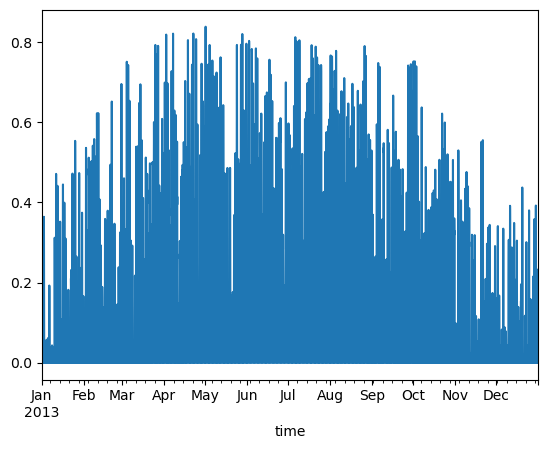

In [54]:
pv.to_pandas().iloc[:,0].plot()

### Wind Profiles

In [55]:
wind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix,
    index=regions.index,
    per_unit=True,
)

In [56]:
wind.to_pandas().head()

GID_1,NLD.1_1,NLD.2_1,NLD.3_1,NLD.4_1,NLD.5_1,NLD.6_1,NLD.7_1,NLD.8_1,NLD.9_1,NLD.10_1,NLD.11_1,NLD.12_1,NLD.13_1,NLD.14_1
time,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.999056,0.998485,0.998294,0.997185,0.998198,0.998937,0.997705,0.998457,0.996653,0.998057,0.996010,0.998684,0.997938,0.995548
2013-01-01 01:00:00,0.991667,0.993051,0.970360,0.995386,0.953421,0.994112,0.997151,0.997635,0.984541,0.997531,0.985574,0.996537,0.992089,0.983092
2013-01-01 02:00:00,0.981956,0.970941,0.933896,0.982949,0.903412,0.974296,0.995252,0.993278,0.939996,0.989856,0.956938,0.968682,0.976204,0.952877
2013-01-01 03:00:00,0.948241,0.870216,0.846933,0.946690,0.840527,0.877124,0.980648,0.951256,0.773720,0.957361,0.852354,0.853057,0.899308,0.837002
2013-01-01 04:00:00,0.770508,0.647249,0.572062,0.846147,0.593890,0.611827,0.921734,0.850735,0.490069,0.841523,0.681832,0.705750,0.730653,0.623015


<AxesSubplot:xlabel='time'>

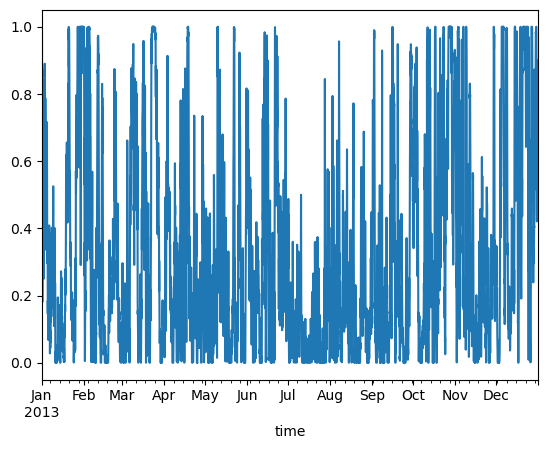

In [57]:
wind.to_pandas().iloc[:,0].plot()

## Merging Shapes in `geopandas`

Spatial data is often more granular than we need. For example, we might have data on sub-national units, but we’re actually interested in studying patterns at the level of countries.

Whereas in `pandas` we would use the `groupby()` function to aggregate entries, in `geopandas`, we aggregate geometric features using the `dissolve()` function.

Suppose we are interested in studying continents, but we only have country-level data like the country dataset included in `geopandas`. We can easily convert this to a continent-level dataset.

:::{note}
See also https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
:::

In [58]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [59]:
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


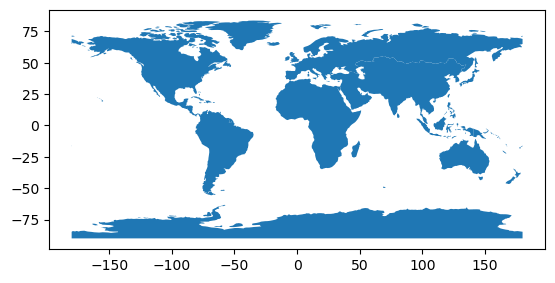

In [60]:
continents = world.dissolve(by='continent').geometry

continents.plot();

If we are interested in the population per continent, we can pass different aggregation strategies to the `dissolve()` functionusing the `aggfunc` argument:

https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html#dissolve-arguments

In [61]:
continents = world.dissolve(by='continent', aggfunc=dict(pop_est='sum'))

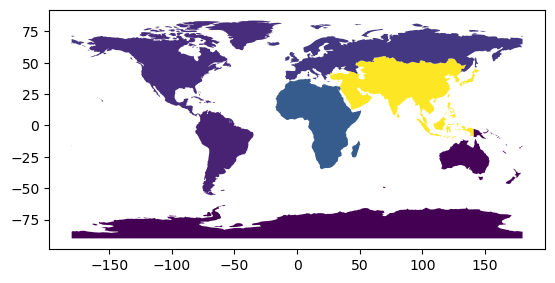

In [62]:
continents.plot(column='pop_est');

You can also pass a `pandas.Series` to the `dissolve()` function that describes your mapping for more exotic aggregation strategies (e.g. by first letter of the country name):

<AxesSubplot:>

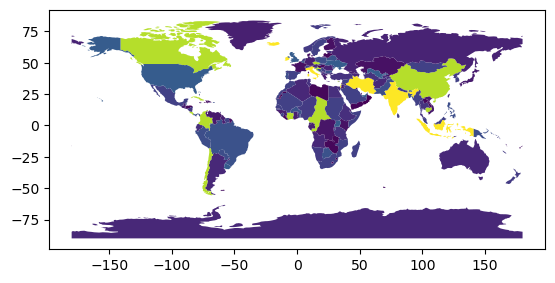

In [63]:
world.dissolve(by=world.name.str[0], aggfunc=dict(pop_est='sum')).plot(column='pop_est')

## Representative Points and Crow-Fly Distances

The following example includes code to retrieve representative points from polygons and to calculate the distance on a sphere between two points.

:::{note}
See also https://en.wikipedia.org/wiki/Haversine_formula

See also https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html
:::

In [64]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [65]:
points = world.representative_point()

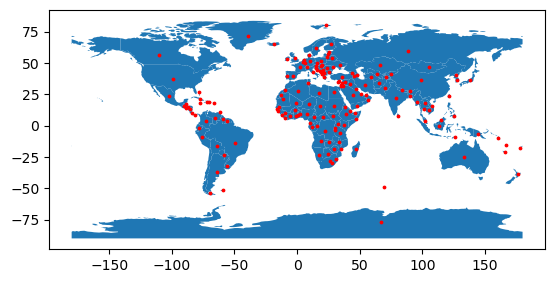

In [66]:
fig, ax = plt.subplots()
world.plot(ax=ax)
points.plot(ax=ax, color='red', markersize=3);

In [67]:
points = points.to_crs(4087)
points.index = world.iso_a3

In [68]:
distances = pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1).div(1e3) # km

In [69]:
distances.loc["DEU", "NLD"]

564.4945392494385

## Global Equal-Area and Equal-Distance CRS

Previously, we used EPSG:3035 as projection to calculate the area of regions in km². However, this projection is not correct for regions outside of Europe, so that we need to pick different, more suitable projections for calculating areas and distances between regions.

- **for calculating distances:** [WGS 84 / World Equidistant Cylindrical (EPSG:4087)](https://epsg.io/4087)

- **for calculating areas:** [Mollweide (ESRI:54009)](https://epsg.io/54009)

The unit of measurement for both projections is metres.

In [70]:
AREA_CRS = "ESRI:54009"
DISTANCE_CRS = "EPSG:4087"

In [71]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

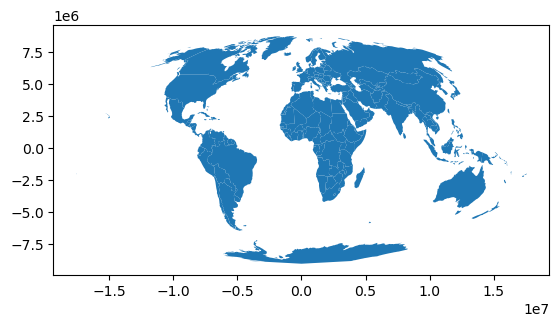

In [72]:
world.to_crs(AREA_CRS).plot()

<AxesSubplot:>

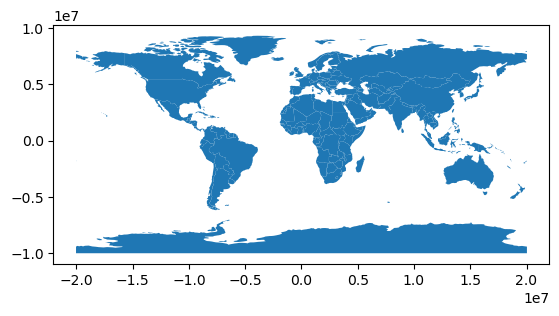

In [73]:
world.to_crs(DISTANCE_CRS).plot()

## Country Converter

> The country converter (coco) is a Python package to convert and match country names between different classifications and between different naming versions. 

:::{note}
See also https://github.com/konstantinstadler/country_converter
:::

In [74]:
import country_converter as coco

Convert various country names to some standard names, specifying source and target classification scheme:

In [75]:
coco.convert(names='NLD', to='name_official')

'Kingdom of the Netherlands'

In [76]:
coco.convert(names='NLD', to='iso2')

'NL'

In [77]:
coco.convert(names='NLD', src='iso3', to='iso2')

'NL'

In [78]:
country_list = ['AE', 'AL', 'AM', 'AO', 'AR']

In [79]:
coco.convert(names=country_list, src='iso2', to='short_name')

['United Arab Emirates', 'Albania', 'Armenia', 'Angola', 'Argentina']

List of included country classification schemes:

In [80]:
cc = coco.CountryConverter()
cc.valid_country_classifications

['DACcode',
 'Eora',
 'FAOcode',
 'GBDcode',
 'GWcode',
 'ISO2',
 'ISO3',
 'ISOnumeric',
 'UNcode',
 'ccTLD',
 'name_official',
 'name_short',
 'regex']

## Gurobi

[Gurobi](https://www.gurobi.com/) is one of the most powerful solvers to solve optimisation problems. 
It is a commercial solver, with free academic licenses.

:::{note}
Using this solver for the group assignment is optional. You can also use other open-source alternatives, but they might just take a little longer to solve.
:::

To set up Gurobi, you need to:

- Register at https://pages.gurobi.com/registration/ with your institutional e-mail address (e.g. `@campus.tu-berlin.de`).
- Follow the getting started guide for your respective operating system at https://www.gurobi.com/documentation/quickstart.html (this includes a guide for retrieving your academic license and installing the software).
- In your `conda` environment, install `gurobipy` with `pip install gurobipy`.
